<a href="https://colab.research.google.com/github/rutuja-patil24/CMPE-255-Data_Mining/blob/main/Assignment_5/SEMMA_analysis_for_the_Telco_Customer_Churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import essential libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score


In [ ]:
# Load the dataset

df = pd.read_csv('/content/WA_Fn-UseC_-Telco-Customer-Churn.csv')

# Display the first few rows of the dataset
df.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
# Convert 'TotalCharges' to numeric and handle missing values
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(subset=['TotalCharges'], inplace=True)

# Check for remaining missing values
print(df.isnull().sum())

# Convert the target variable 'Churn' to binary (1 for 'Yes', 0 for 'No')
df['Churn'] = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)


customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


In [ ]:
# Features (X) and Target (y)
X = df.drop(columns=['customerID', 'Churn'])
y = df['Churn']

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shape of the datasets
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")


Training set shape: (5625, 19)
Test set shape: (1407, 19)


<ipython-input-7-b9aa1e0e3edc>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Churn', data=df, palette='Set1')


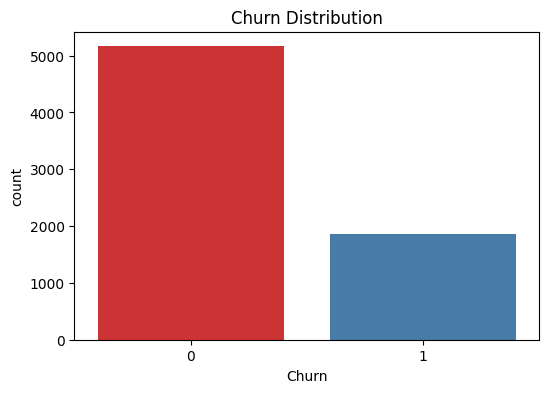

In [ ]:
# Churn distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='Churn', data=df, palette='Set1')
plt.title('Churn Distribution')
plt.show()

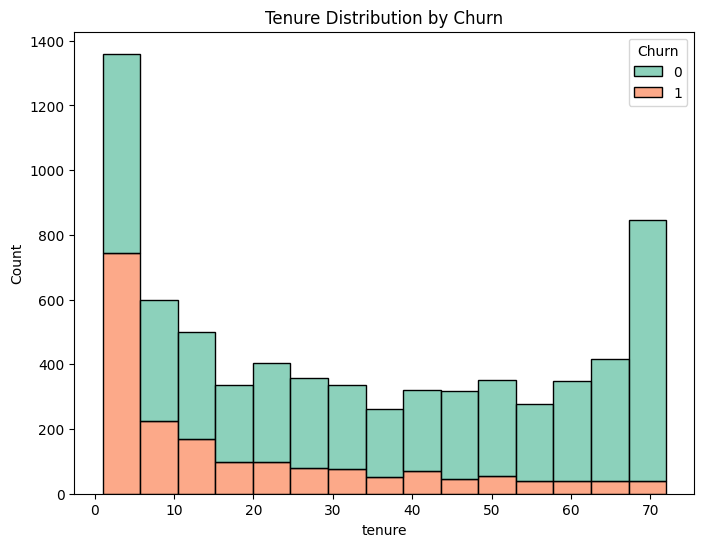

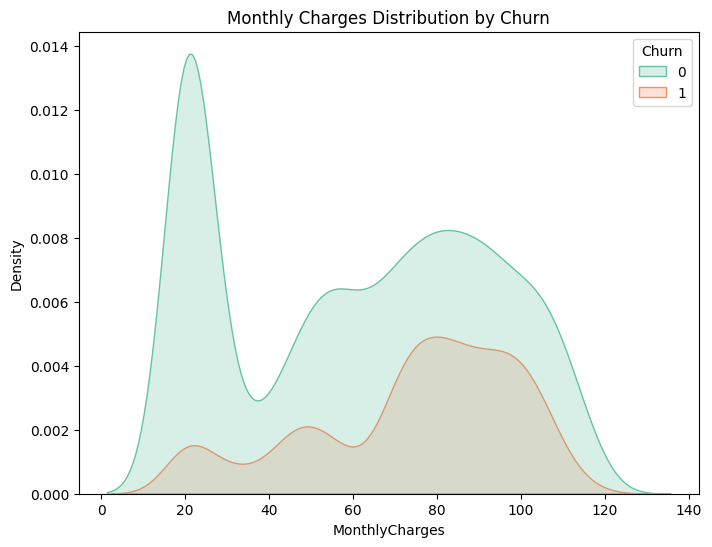

In [ ]:
# Tenure distribution by churn
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='tenure', hue='Churn', multiple='stack', palette='Set2')
plt.title('Tenure Distribution by Churn')
plt.show()

# Monthly Charges distribution by churn
plt.figure(figsize=(8, 6))
sns.kdeplot(data=df, x='MonthlyCharges', hue='Churn', fill=True, palette='Set2')
plt.title('Monthly Charges Distribution by Churn')
plt.show()


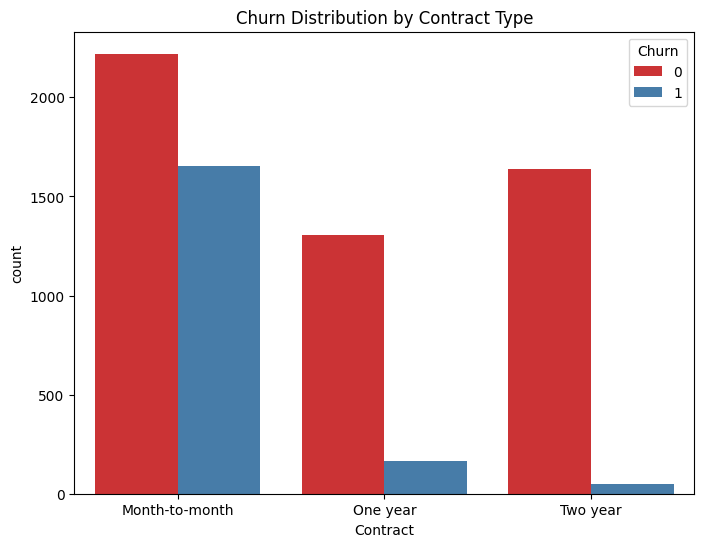

In [ ]:
# Contract type vs churn
plt.figure(figsize=(8, 6))
sns.countplot(x='Contract', hue='Churn', data=df, palette='Set1')
plt.title('Churn Distribution by Contract Type')
plt.show()


In [ ]:
# One-hot encode categorical variables
X_train_encoded = pd.get_dummies(X_train, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, drop_first=True)

# Ensure training and test sets have the same columns
X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join='left', axis=1, fill_value=0)


In [ ]:
# Scaling numerical features
scaler = StandardScaler()
numerical_columns = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Scale the training and test sets
X_train_encoded[numerical_columns] = scaler.fit_transform(X_train_encoded[numerical_columns])
X_test_encoded[numerical_columns] = scaler.transform(X_test_encoded[numerical_columns])

# Check the scaled data
X_train_encoded.head()


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
6030,0,0.434674,-0.518620,-0.087908,False,False,False,False,True,False,...,False,True,False,True,False,False,True,False,False,False
3410,0,-1.195652,-0.374443,-0.921285,True,False,False,True,False,False,...,False,True,False,False,False,False,False,True,False,False
5483,0,0.923772,0.432616,0.963781,False,True,False,True,False,True,...,False,False,False,False,False,False,True,False,True,False
5524,0,0.516190,-0.333013,0.122920,True,True,True,True,False,False,...,False,False,False,False,False,True,False,False,False,False
6337,0,0.923772,1.199902,1.401088,False,True,True,True,False,True,...,False,True,False,True,True,False,False,False,False,True


In [ ]:
# Logistic Regression
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train_encoded, y_train)

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_encoded, y_train)

# XGBoost
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train_encoded, y_train)

# Evaluate using cross-validation accuracy
logreg_score = cross_val_score(logreg, X_train_encoded, y_train, cv=5, scoring='accuracy').mean()
rf_score = cross_val_score(rf, X_train_encoded, y_train, cv=5, scoring='accuracy').mean()
xgb_score = cross_val_score(xgb, X_train_encoded, y_train, cv=5, scoring='accuracy').mean()

print(f'Logistic Regression Accuracy: {logreg_score:.4f}')
print(f'Random Forest Accuracy: {rf_score:.4f}')
print(f'XGBoost Accuracy: {xgb_score:.4f}')


Logistic Regression Accuracy: 0.8068
Random Forest Accuracy: 0.7963
XGBoost Accuracy: 0.7925


XGBoost Classification Report
              precision    recall  f1-score   support

           0       0.82      0.87      0.84      1033
           1       0.57      0.47      0.51       374

    accuracy                           0.76      1407
   macro avg       0.69      0.67      0.68      1407
weighted avg       0.75      0.76      0.76      1407



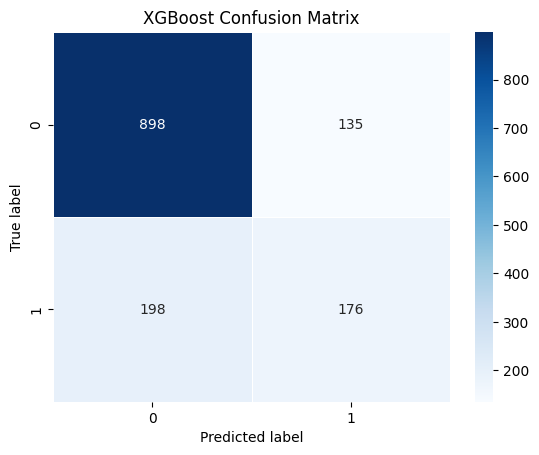

In [ ]:
# Predict using XGBoost
y_pred_xgb = xgb.predict(X_test_encoded)

# Classification report for XGBoost
print('XGBoost Classification Report')
print(classification_report(y_test, y_pred_xgb))

# Confusion matrix for XGBoost
conf_matrix = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', linewidths=0.5)
plt.title('XGBoost Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


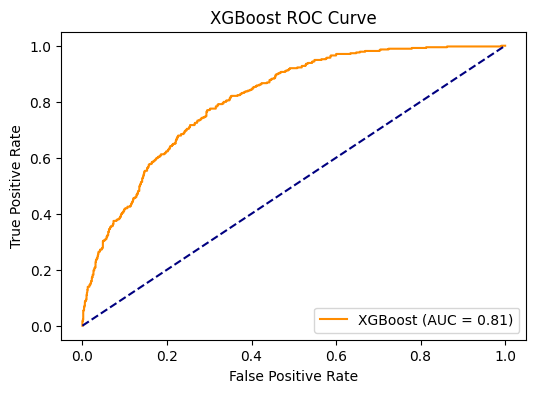

XGBoost ROC-AUC: 0.8097


In [ ]:
# ROC-AUC Curve for XGBoost
y_pred_prob_xgb = xgb.predict_proba(X_test_encoded)[:, 1]
roc_auc_xgb = roc_auc_score(y_test, y_pred_prob_xgb)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_prob_xgb)

plt.figure(figsize=(6, 4))
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_xgb:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost ROC Curve')
plt.legend(loc='lower right')
plt.show()

print(f'XGBoost ROC-AUC: {roc_auc_xgb:.4f}')


In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Create a GridSearchCV object for Random Forest
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=5, n_jobs=-1, verbose=2)
grid_search_rf.fit(X_train_encoded, y_train)

# Best parameters for Random Forest
print(f'Best parameters for Random Forest: {grid_search_rf.best_params_}')
best_rf = grid_search_rf.best_estimator_

# XGBoost parameter grid
param_grid_xgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

# Create a GridSearchCV object for XGBoost
grid_search_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid_xgb, cv=5, n_jobs=-1, verbose=2)
grid_search_xgb.fit(X_train_encoded, y_train)

# Best parameters for XGBoost
print(f'Best parameters for XGBoost: {grid_search_xgb.best_params_}')
best_xgb = grid_search_xgb.best_estimator_


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters for Random Forest: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


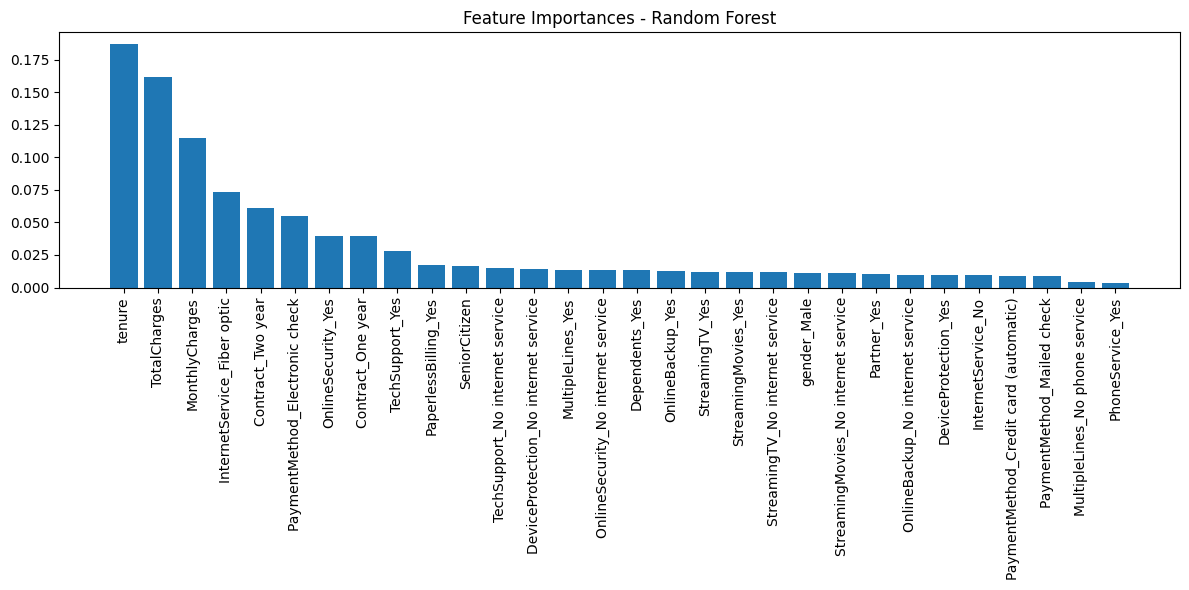

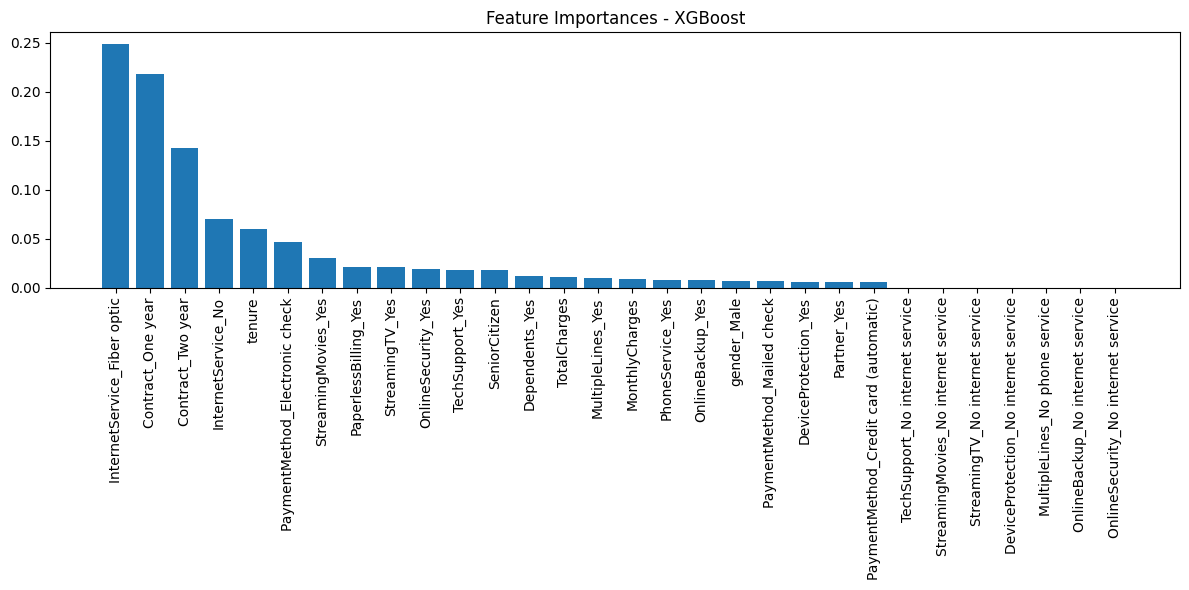

In [ ]:
# Feature importance for Random Forest
importances_rf = best_rf.feature_importances_
indices_rf = np.argsort(importances_rf)[::-1]

plt.figure(figsize=(12, 6))
plt.title('Feature Importances - Random Forest')
plt.bar(range(X_train_encoded.shape[1]), importances_rf[indices_rf], align='center')
plt.xticks(range(X_train_encoded.shape[1]), X_train_encoded.columns[indices_rf], rotation=90)
plt.tight_layout()
plt.show()

# Feature importance for XGBoost
importances_xgb = best_xgb.feature_importances_
indices_xgb = np.argsort(importances_xgb)[::-1]

plt.figure(figsize=(12, 6))
plt.title('Feature Importances - XGBoost')
plt.bar(range(X_train_encoded.shape[1]), importances_xgb[indices_xgb], align='center')
plt.xticks(range(X_train_encoded.shape[1]), X_train_encoded.columns[indices_xgb], rotation=90)
plt.tight_layout()
plt.show()


In [ ]:
# Install imbalanced-learn package if needed
from imblearn.over_sampling import SMOTE

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_encoded, y_train)

# Check the distribution of classes after SMOTE
print(f'Class distribution after SMOTE: {np.bincount(y_train_smote)}')


Class distribution after SMOTE: [4130 4130]
